In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import random
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import noisereduce as nr

## Data Preprocess

In [4]:
emo_labels = {'W': 0, 'L': 1, 'E': 2, 'A': 3, 'F': 4, 'T': 5, 'N': 6}

def get_label(file_name):
    label = file_name[5]
    return emo_labels[label]
    
def resizeMFCC(mfccs, target_steps):
    if mfccs.shape[1] < target_steps:
        padding = target_steps - mfccs.shape[1]
        mfccs_resized = np.pad(mfccs, ((0, 0), (0, padding)), mode='constant')
    elif mfccs.shape[1] > target_steps:
        mfccs_resized = mfccs[:, :target_steps]
    else:
        mfccs_resized = mfccs
    return mfccs_resized

In [5]:
n_coeff = 13
max_length = 150
labels = []
waveforms = []
MFCCs = []

for file_name in os.listdir('data/wav'):
    label = get_label(file_name)
    file_path = os.path.join('data/wav', file_name)   
    w, sr = librosa.load(file_path)
    for i in range(3):
        rand1 = -3 + random.random() * 6
        w_pitch_shifted = librosa.effects.pitch_shift(w, sr=sr, n_steps=rand1)
        w_pitch_shifted = nr.reduce_noise(y=w_pitch_shifted, sr=sr, prop_decrease=0.8)
        MFCC_pitch_shifted = librosa.feature.mfcc(y=w_pitch_shifted, sr=sr, n_mfcc=n_coeff)
        MFCC_pitch_shifted = librosa.util.normalize(MFCC_pitch_shifted, axis=1)
        MFCC_pitch_shifted = resizeMFCC(MFCC_pitch_shifted, max_length)
        MFCCs.append(MFCC_pitch_shifted)
        labels.append(label)
            
        rand2 = 0.8 + random.random() * 0.4
        w_time_stretched = librosa.effects.time_stretch(w, rate=rand2)
        w_time_stretched = nr.reduce_noise(y=w_time_stretched, sr=sr, prop_decrease=0.8)
        MFCC_time_stretched = librosa.feature.mfcc(y=w_time_stretched, sr=sr, n_mfcc=n_coeff)
        MFCC_time_stretched = librosa.util.normalize(MFCC_time_stretched, axis=1)
        MFCC_time_stretched = resizeMFCC(MFCC_time_stretched, max_length)
        MFCCs.append(MFCC_time_stretched)
        labels.append(label)

    w = nr.reduce_noise(y=w, sr=sr, prop_decrease=0.8)
    MFCC_w = librosa.feature.mfcc(y=w, sr=sr, n_mfcc=n_coeff)
    MFCC_w = librosa.util.normalize(MFCC_w, axis=1)
    MFCC_w = resizeMFCC(MFCC_w, max_length)
    MFCCs.append(MFCC_w)
    labels.append(label)


In [6]:
len(MFCCs), len(labels)

(3745, 3745)

In [7]:
from tensorflow.keras.utils import to_categorical

y = np.array(labels)
num_classes = len(np.unique(y))
y = to_categorical(y)

X = np.array(MFCCs)
X = X[..., np.newaxis]

print(X.shape)
print(y.shape)
print(num_classes)

(3745, 13, 150, 1)
(3745, 7)
7


## Training model

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2621, 13, 150, 1),
 (2621, 7),
 (562, 13, 150, 1),
 (562, 7),
 (562, 13, 150, 1),
 (562, 7))

### Categorical Cross Entropy loss function

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 11, 148, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 11, 148, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 74, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 74, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 72, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 72, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 36, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 36, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,143 (1.20 MB)

 Trainable params: 314,951 (1.20 MB)

 Non-trainable params: 192 (768.00 B)

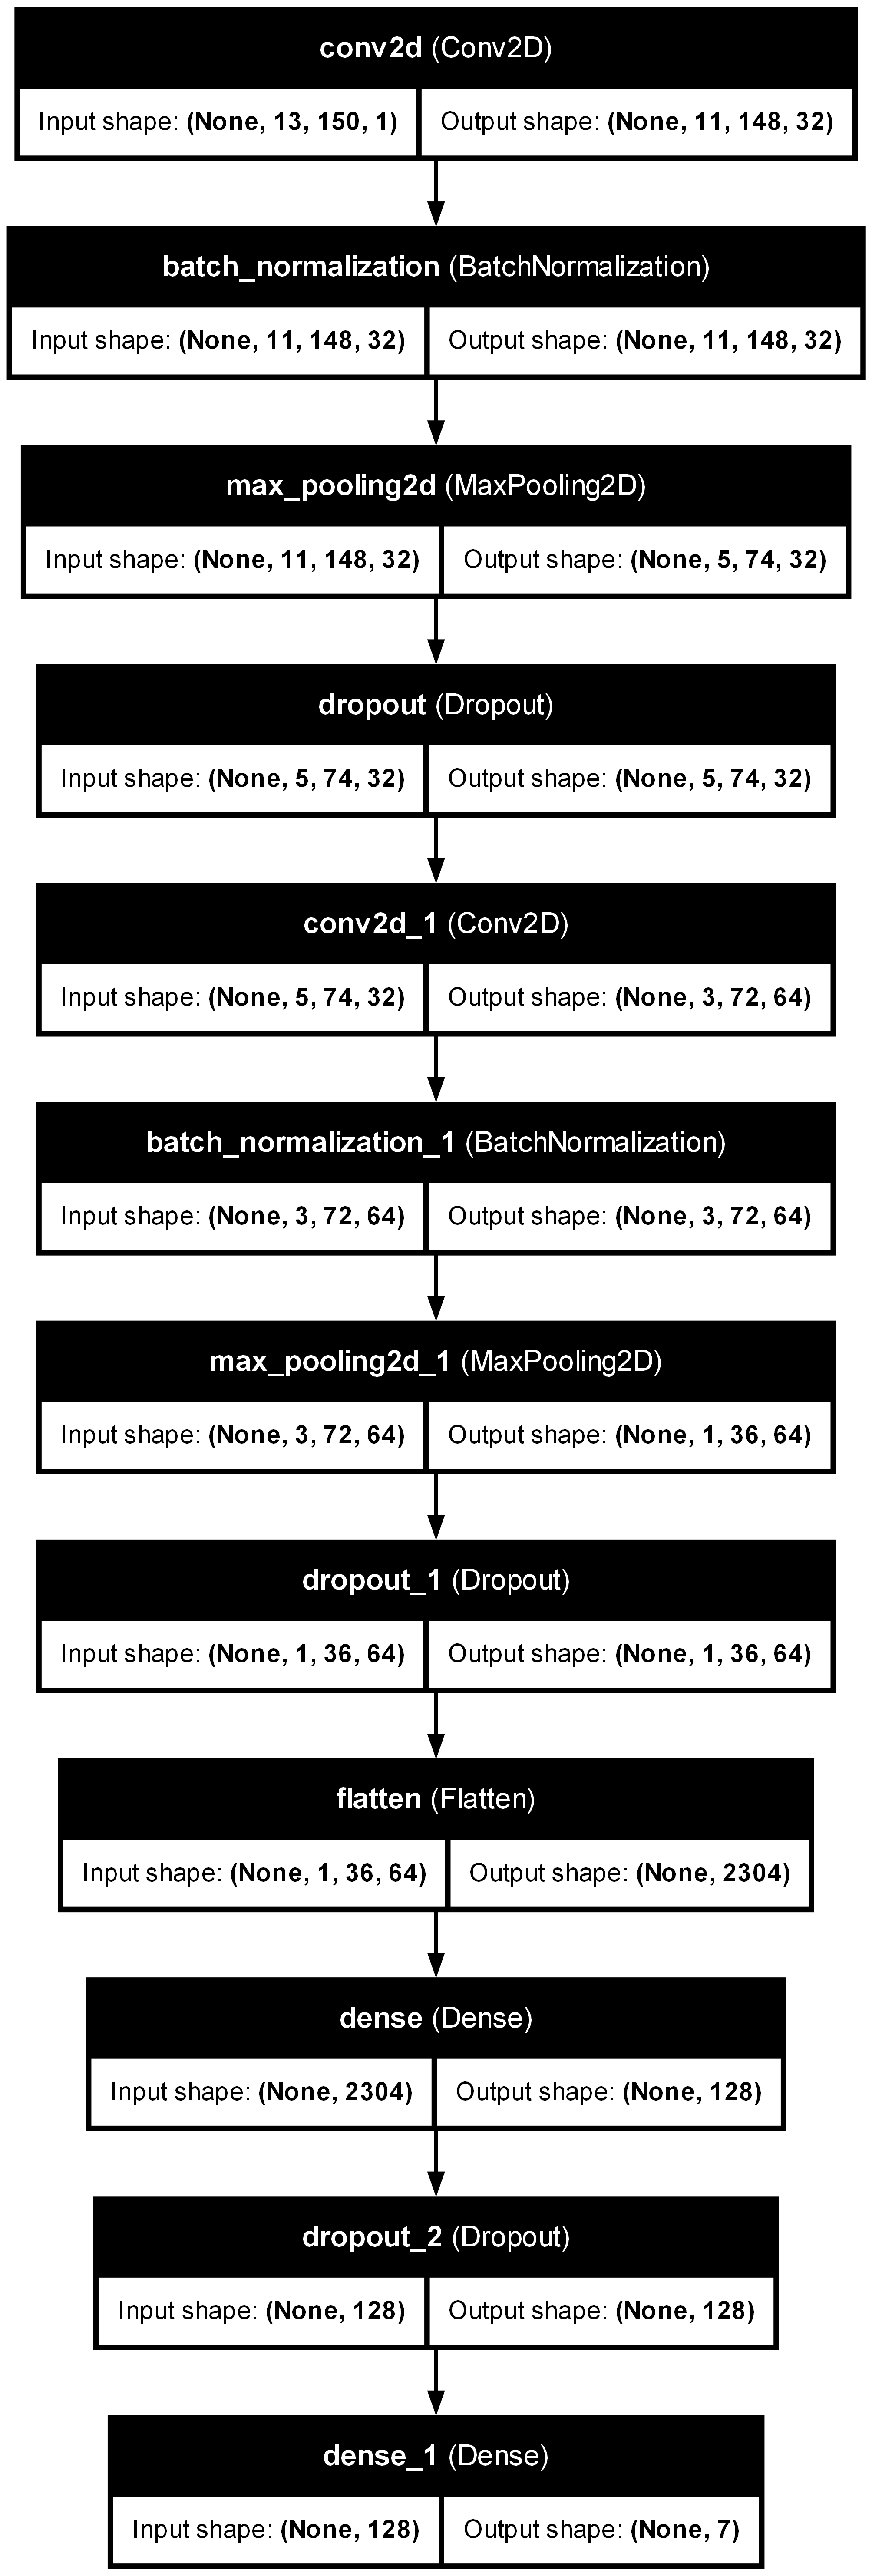

In [11]:
from tensorflow.keras import layers, models, optimizers, Input
from tensorflow.keras.optimizers import Adam,SGD

model1 = models.Sequential()
model1.add(Input(shape=(13, 150, 1)))
model1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Dropout(0.5))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Dropout(0.5))
model1.add(layers.Flatten())

model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(num_classes, activation='softmax'))


model1.summary()

from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='cnn_structure.png', show_shapes=True, show_layer_names=True, dpi=300)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

model1.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = model1.fit(X_train, y_train,epochs=50,validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.2310 - loss: 3.1487 - val_accuracy: 0.1388 - val_loss: 3.5085
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3468 - loss: 1.6374 - val_accuracy: 0.2028 - val_loss: 5.1611
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.4054 - loss: 1.5240 - val_accuracy: 0.2206 - val_loss: 5.5376
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.4332 - loss: 1.4059 - val_accuracy: 0.3025 - val_loss: 4.7522
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4775 - loss: 1.2900 - val_accuracy: 0.3968 - val_loss: 3.1666
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5238 - loss: 1.2115 - val_accuracy: 0.5089 - val_loss: 1.7729
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5531 - loss: 1.1491 - val_accuracy: 0.5641 - val_loss: 1.1957
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5482 - loss: 1.1019 - val_accuracy: 0.6317 - v

In [13]:
test_loss, test_accuracy = model1.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9107 - loss: 0.2988
Test Accuracy: 0.9163700938224792


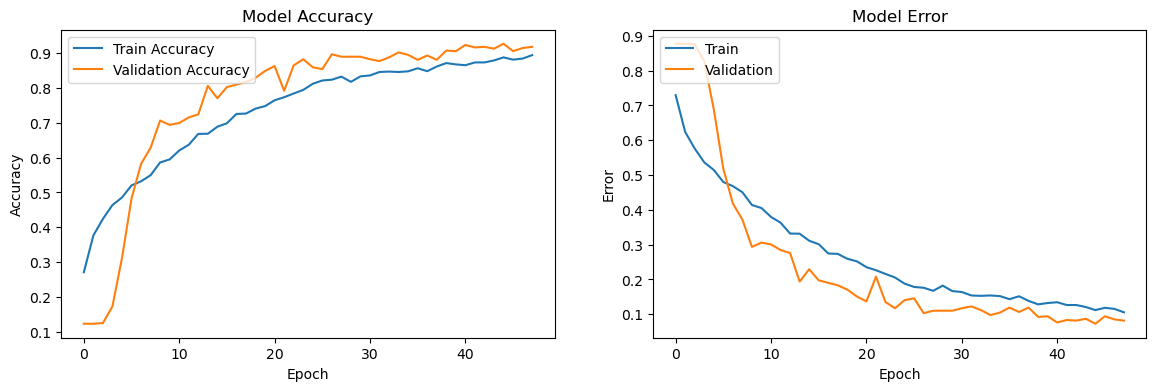

In [43]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

train_error = 1 - np.array(history.history['accuracy'])
val_error = 1 - np.array(history.history['val_accuracy'])

plt.subplot(1, 2, 2)
plt.plot(train_error, label='Train Error')
plt.plot(val_error, label='Validation Error')
plt.title('Model Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig('EMO_cnn_loss1', dpi=300, bbox_inches='tight')
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<Figure size 700x700 with 0 Axes>

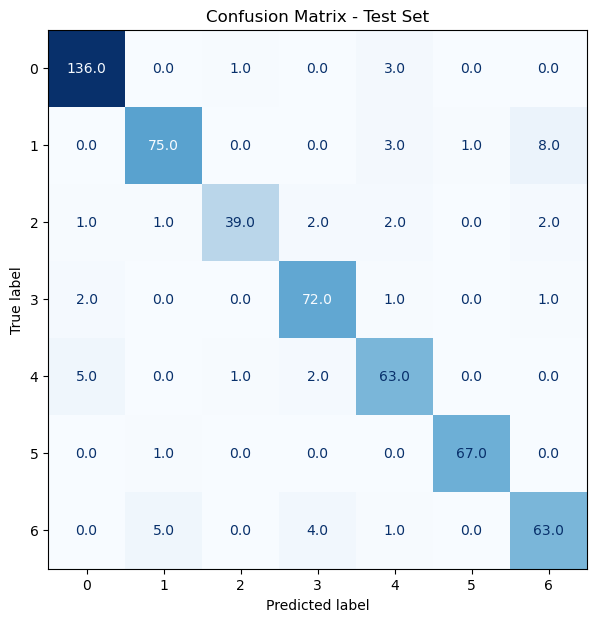

<Figure size 700x700 with 0 Axes>

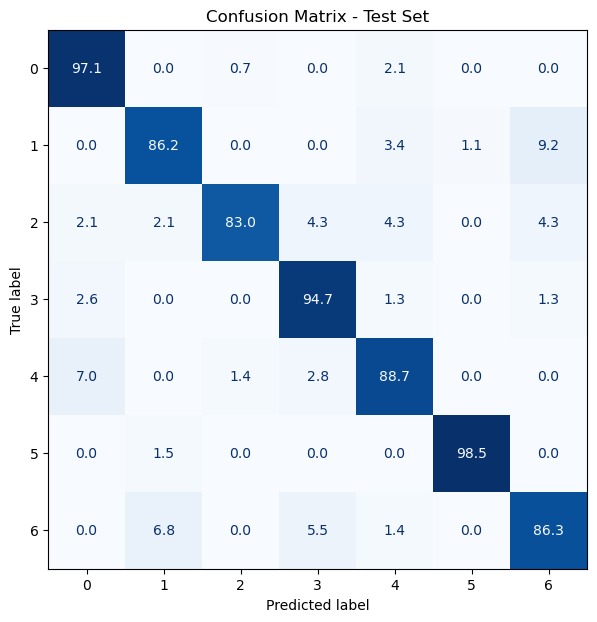

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test_pred = model1.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

cm_test = confusion_matrix(y_test_argmax, y_test_pred_classes)
cm_test_percent = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis] * 100

plt.figure()
plt.rcParams['figure.figsize'] = [7, 7]
disp_test = ConfusionMatrixDisplay(cm_test, display_labels=np.arange(num_classes))
disp_test.plot(cmap=plt.cm.Blues,colorbar=False , values_format='.1f')
plt.title('Confusion Matrix - Test Set')
plt.savefig('cnn_loss1_cm', dpi=300, bbox_inches='tight')
plt.show()

plt.figure()
plt.rcParams['figure.figsize'] = [7, 7]
disp_test = ConfusionMatrixDisplay(cm_test_percent, display_labels=np.arange(num_classes))
disp_test.plot(cmap=plt.cm.Blues,colorbar=False , values_format='.1f')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [61]:
from sklearn.metrics import classification_report
report = classification_report(y_test_argmax, y_test_pred_classes)#, target_names=list(labels.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       140
           1       0.91      0.86      0.89        87
           2       0.95      0.83      0.89        47
           3       0.90      0.95      0.92        76
           4       0.86      0.89      0.88        71
           5       0.99      0.99      0.99        68
           6       0.85      0.86      0.86        73

    accuracy                           0.92       562
   macro avg       0.92      0.91      0.91       562
weighted avg       0.92      0.92      0.92       562



### Kullback-Leibler Divergence loss function

In [17]:
from tensorflow.keras import layers, models, optimizers, Input
from tensorflow.keras.optimizers import Adam,SGD

model2 = models.Sequential()
model2.add(Input(shape=(13, 150, 1)))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Flatten())

model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(num_classes, activation='softmax'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 11, 148, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 148, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 74, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 74, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 72, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 72, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 36, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 36, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,143 (1.20 MB)

 Trainable params: 314,951 (1.20 MB)

 Non-trainable params: 192 (768.00 B)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

model2.compile(optimizer=Adam(learning_rate=1e-3), loss='kld', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = model2.fit(X_train, y_train,epochs=50,validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.2318 - loss: 2.9926 - val_accuracy: 0.1228 - val_loss: 3.0264
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3626 - loss: 1.5652 - val_accuracy: 0.1228 - val_loss: 4.8997
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4165 - loss: 1.4179 - val_accuracy: 0.1246 - val_loss: 4.7974
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.4550 - loss: 1.3437 - val_accuracy: 0.1726 - val_loss: 4.5506
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4720 - loss: 1.2552 - val_accuracy: 0.3114 - val_loss: 2.5007
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5108 - loss: 1.1781 - val_accuracy: 0.4822 - val_loss: 1.4852
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5340 - loss: 1.1099 - val_accuracy: 0.5819 - val_loss: 1.0422
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5357 - loss: 1.1234 - val_accuracy: 0.6281 - v

In [19]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9004 - loss: 0.2868
Test Accuracy: 0.900355875492096


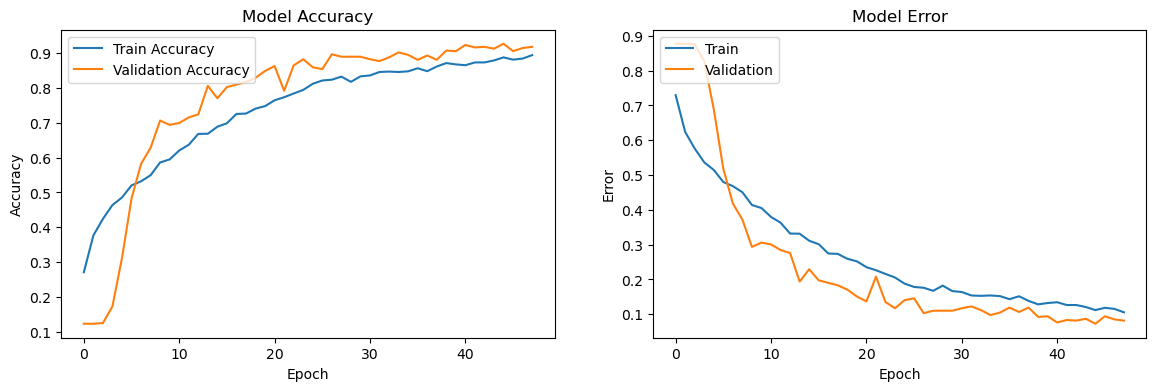

In [46]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

train_error = 1 - np.array(history.history['accuracy'])
val_error = 1 - np.array(history.history['val_accuracy'])

plt.subplot(1, 2, 2)
plt.plot(train_error, label='Train Error')
plt.plot(val_error, label='Validation Error')
plt.title('Model Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig('EMO_cnn_loss2', dpi=300, bbox_inches='tight')
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


<Figure size 700x700 with 0 Axes>

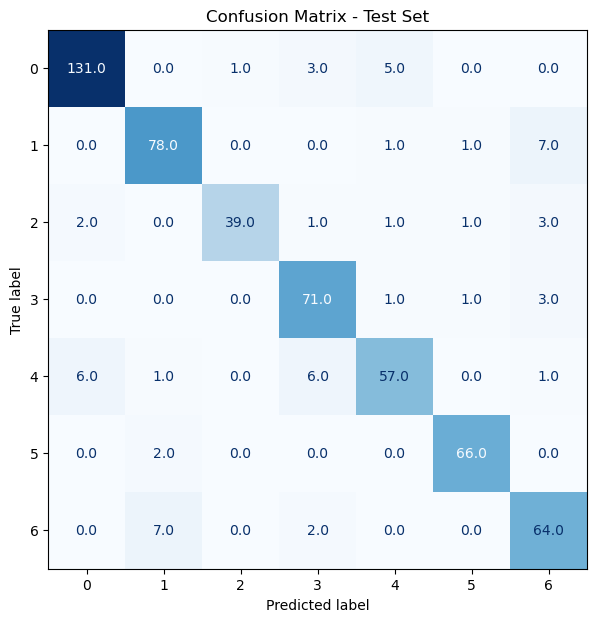

<Figure size 700x700 with 0 Axes>

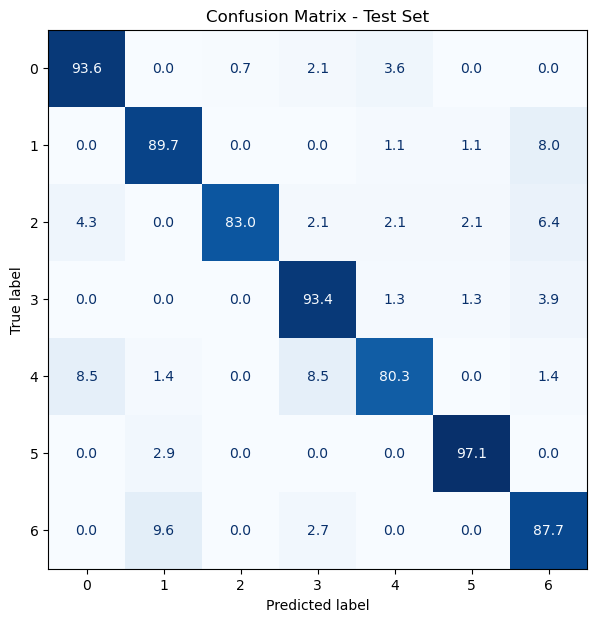

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test_pred = model2.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

cm_test = confusion_matrix(y_test_argmax, y_test_pred_classes)
cm_test_percent = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis] * 100

plt.figure()
plt.rcParams['figure.figsize'] = [7, 7]
disp_test = ConfusionMatrixDisplay(cm_test, display_labels=np.arange(num_classes))
disp_test.plot(cmap=plt.cm.Blues,colorbar=False , values_format='.1f')
plt.title('Confusion Matrix - Test Set')
plt.savefig('cnn_loss2_cm', dpi=300, bbox_inches='tight')
plt.show()

plt.figure()
plt.rcParams['figure.figsize'] = [7,7]
disp_test = ConfusionMatrixDisplay(cm_test_percent, display_labels=np.arange(num_classes))
disp_test.plot(cmap=plt.cm.Blues,colorbar=False , values_format='.1f')
plt.title('Confusion Matrix - Test Set')
plt.show()